# Projet Machine Learning (Classification)
**Abdeljabbar RACHID**

# Classification de la variable Rings

## 1. Importation des bibliothèques et des données

In [9]:
# Importation des bibliothèques nécessaires
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# fetch dataset
abalone = fetch_ucirepo(id=1)
Abalone = pd.DataFrame(abalone.data.features)
Abalone['Rings'] = abalone.data.targets
pd.DataFrame(abalone.variables)

,name,role,type,demographic,description,units,missing_values
0,Sex,Feature,Categorical,None,"M, F, and I (infant)",None,no
1,Length,Feature,Continuous,None,Longest shell measurement,mm,no
2,Diameter,Feature,Continuous,None,perpendicular to length,mm,no
3,Height,Feature,Continuous,None,with meat in shell,mm,no
4,Whole_weight,Feature,Continuous,None,whole abalone,grams,no
5,Shucked_weight,Feature,Continuous,None,weight of meat,grams,no
6,Viscera_weight,Feature,Continuous,None,gut weight (after bleeding),grams,no
7,Shell_weight,Feature,Continuous,None,after being dried,grams,no
8,Rings,Target,Integer,None,+1.5 gives the age in years,None,no


La variable Sex est catégorielle donc doit être encodée avant utilisation dans les modèles de classification. et pour cela nous allons appliquer la fonction `pd.get_dummies`

In [12]:
# Encodage des variables catégorielles pour la colonne 'Sex'
Abalone = pd.get_dummies(Abalone, columns=['Sex'], prefix=['Sex'])
Abalone.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,True,False


##2. Catégorisation de la variable cible

In [13]:
# Fonction pour catégoriser les anneaux en classes
def categorize_rings(rings):
    if rings <= 8:
        return "Jeune"
    elif 9 <= rings <= 10:
        return "Adulte"
    else:
        return "Vieux"

# Application de la fonction à la colonne 'Rings'
Abalone['Category'] = Abalone['Rings'].apply(categorize_rings)

# Suppression de la colonne 'Rings' (car nous avons créé 'Category')
Abalone.drop(columns=['Rings'], inplace=True)

# Aperçu après la transformation
print(Abalone['Category'].value_counts())


Category
Vieux     1447
Jeune     1407
Adulte    1323
Name: count, dtype: int64


La répartition des classes est globalement équilibré
(aucune classe n'est fortement dominante ou sous-représentée).
Étant donné l'équilibre relatif entre les classes, l'accuracy est une métrique pertinente, mais il est recommandé d'examiner également d'autres indicateurs comme le F1-Score ou la matrice de confusion afin de détecter d'éventuels biais.

##3. Séparation des données (X, y) et division en ensembles d'entraînement et de test

In [14]:
# Définition des variables explicatives (X) et cible (y)
X = Abalone.drop(columns=['Category'])
y = Abalone['Category']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisation des données pour k-NN et la régression logistique: ar ces algorithmes sont sensibles aux échelles des variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##4. Régression Logistique avec recherche d'hyperparamètres

In [15]:
# Recherche d'hyperparamètres pour la régression logistique
params_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=500, random_state=42), params_lr, cv=3, scoring='accuracy')
grid_lr.fit(X_train, y_train)

# Meilleur modèle et évaluation
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("\nRégression Logistique :")
print("Meilleurs paramètres :", grid_lr.best_params_)
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Rapport de classification :\n", classification_report(y_test, y_pred_lr))


Régression Logistique :
Meilleurs paramètres : {'C': 10, 'penalty': 'l2'}
Accuracy : 0.6208133971291866
Rapport de classification :
               precision    recall  f1-score   support

      Adulte       0.47      0.52      0.50       265
       Jeune       0.72      0.79      0.75       281
       Vieux       0.68      0.55      0.61       290

    accuracy                           0.62       836
   macro avg       0.62      0.62      0.62       836
weighted avg       0.63      0.62      0.62       836



La régression logistique, avec les paramètres optimaux {C: 10, penalty: 'l2'}, atteint une accuracy globale de 62%. Les scores montrent une bonne précision pour les classes "Jeune" (72%) et "Vieux" (68%), mais une performance plus faible pour "Adulte" (47%). Cela indique que le modèle différencie mieux les classes "Jeune" et "Vieux" que "Adulte", comme confirmé par le recall et les f1-scores.

##5. k-NN avec recherche d'hyperparamètres

In [16]:
# Recherche d'hyperparamètres pour k-NN
params_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), params_knn, cv=3, scoring='accuracy')
grid_knn.fit(X_train, y_train)

# Meilleur modèle et évaluation
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("\nk-NN :")
print("Meilleurs paramètres :", grid_knn.best_params_)
print("Accuracy :", accuracy_score(y_test, y_pred_knn))
print("Rapport de classification :\n", classification_report(y_test, y_pred_knn))


k-NN :
Meilleurs paramètres : {'n_neighbors': 9, 'weights': 'uniform'}
Accuracy : 0.604066985645933
Rapport de classification :
               precision    recall  f1-score   support

      Adulte       0.45      0.55      0.49       265
       Jeune       0.75      0.74      0.75       281
       Vieux       0.65      0.52      0.58       290

    accuracy                           0.60       836
   macro avg       0.62      0.60      0.61       836
weighted avg       0.62      0.60      0.61       836



Le modèle k-NN, avec 9 voisins et des poids uniformes, atteint une accuracy de 60.4 %. La classe "Jeune" est la mieux prédite (f1-score de 0.75), tandis que les classes "Adulte" et "Vieux" ont des performances plus faibles (f1-scores de 0.49 et 0.58). Cela montre une difficulté à discriminer les classes proches.

##6. Random Forest avec recherche d'hyperparamètres

In [17]:
# Recherche d'hyperparamètres pour Random Forest
params_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'max_features': ['sqrt', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), params_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# Meilleur modèle et évaluation
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\nRandom Forest :")
print("Meilleurs paramètres :", grid_rf.best_params_)
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Rapport de classification :\n", classification_report(y_test, y_pred_rf))



Random Forest :
Meilleurs paramètres : {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy : 0.6267942583732058
Rapport de classification :
               precision    recall  f1-score   support

      Adulte       0.49      0.44      0.46       265
       Jeune       0.71      0.77      0.74       281
       Vieux       0.66      0.66      0.66       290

    accuracy                           0.63       836
   macro avg       0.62      0.62      0.62       836
weighted avg       0.62      0.63      0.62       836



**Meilleurs paramètres** : Le modèle a choisi une profondeur maximale de 5 (max_depth=5), une échantillonnage des caractéristiques par racine carrée (max_features='sqrt') et 100 estimateurs. Cela équilibre bien généralisation et complexité.

**Performance globale** : L'accuracy est de 62,68%, légèrement meilleure que celle de la régression logistique et du k-NN. Les scores de précision, rappel et F1 montrent une gestion correcte des données déséquilibrées.

**Analyse par classe** : La classe "Adulte" est moins bien prédite (précision et rappel de 46%), tandis que "Jeune" et "Vieux" ont de meilleurs scores F1 (74% et 66%).

##7. Matrices de confusion pour les trois modèles

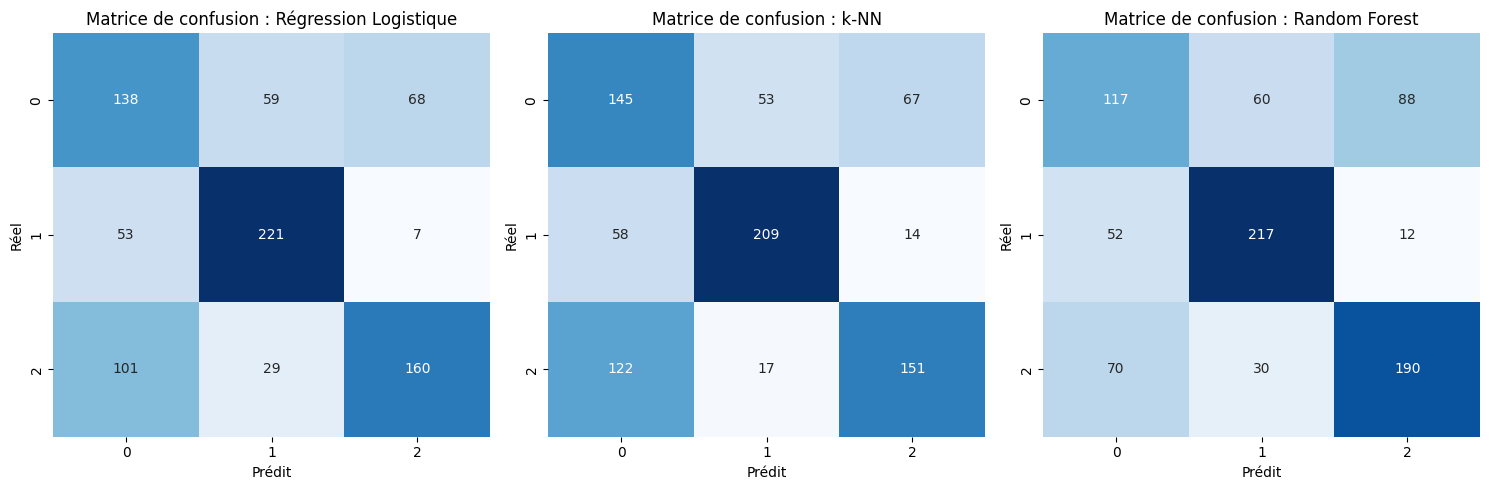

In [18]:
# Création de matrices de confusion
models = {'Régression Logistique': y_pred_lr, 'k-NN': y_pred_knn, 'Random Forest': y_pred_rf}

plt.figure(figsize=(15, 5))
for i, (name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matrice de confusion : {name}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
plt.tight_layout()
plt.show()

  **Régression Logistique** : La classe "Jeune" est bien prédite (221 corrects), mais "Adulte" et "Vieux" sont fréquemment confondus, réduisant la précision.

  **k-NN** : Les performances restent similaires à la régression logistique, avec une légère amélioration pour "Vieux" (151 corrects). Cependant, "Adulte" reste mal classée.

  **Random Forest** : Offre les meilleurs résultats, notamment pour "Vieux" (190 corrects) et "Jeune" (217 corrects). La classe "Adulte" reste un point faible.

Résumé : Random Forest est globalement le plus performant, mais la distinction pour la classe "Adulte" demeure problématique.

## 8. Comparaison des performances (accuracy)

/tmp/ipython-input-19-442202615.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Modèle', data=df_results, palette='viridis')


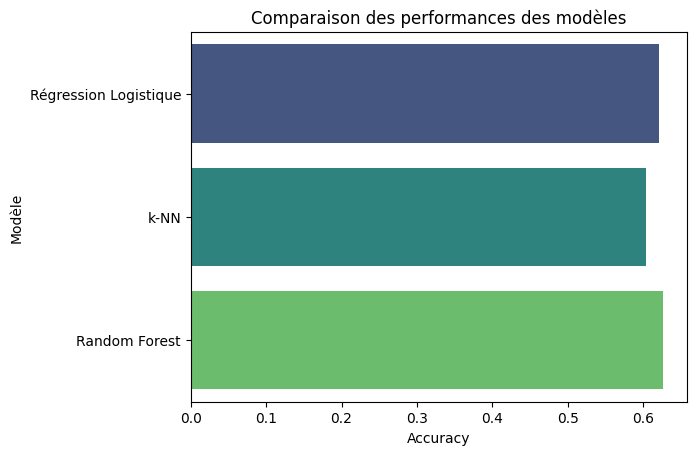

In [19]:
# Comparaison des performances
results = {
    'Modèle': ['Régression Logistique', 'k-NN', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_rf)
    ]
}

df_results = pd.DataFrame(results)
sns.barplot(x='Accuracy', y='Modèle', data=df_results, palette='viridis')
plt.title("Comparaison des performances des modèles")
plt.xlabel("Accuracy")
plt.ylabel("Modèle")
plt.show()


Le graphique compare les performances globales des trois modèles. On constate que :

 **Random Forest** a la meilleure accuracy, légèrement supérieure à celle des autres modèles (~62.7%).

 **k-NN** et **Régression Logistique** affichent des performances similaires, avec une légère avance pour le k-NN.